## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

2023-01-25 07:57:35.036283: W tensorflow/stream_executor/platform/default/dso_loader.cc:65] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-25 07:57:35.036325: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-25 07:57:35.036349: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist


## Step 1: Data Reading and Understanding

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

In [3]:
# Inspect the dataframe to understand the given data.
df.shape

(78313, 22)

In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

## Step 2: Data Cleaning

In [5]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']

In [6]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [7]:
#Assign nan in place of blanks in the complaints column
df["complaint_what_happened"].replace(["", " "], np.nan, inplace=True)

In [8]:
#Remove all rows where complaints column is nan
df.dropna(subset=["complaint_what_happened"], inplace=True)

In [9]:
df.shape

(21072, 22)

## Step 3: Data Preprocessing

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [30]:
# Write your function here to clean the text and remove all the unnecessary elements.
def text_preprocess(text):
    text=text.lower() # To lowercase
    text=re.sub(r'\[.*?\]','',text) # Remove text between []
    text=re.sub(r'[%s]%re.escape(string.punctuation)','',text) # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text) # Remove word with numbers
    return text

In [31]:
#Write your function to Lemmatize the texts
def text_lemma(text):
    lemmas = [word.lemma_ for word in nlp(text)]
    return " ".join(lemmas)

In [32]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df['complaints_cleaned'] = df.complaint_what_happened.apply(text_preprocess)

In [33]:
df["complaints_lemmatized"] = df.complaints_cleaned.apply(text_lemma)

In [34]:
df_clean=df[['complaints_cleaned','complaints_lemmatized']]

In [35]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
    nn_words = []
    doc = nlp(text)
    for tok in doc:
        if(tok.tag_ == 'NN'):
            nn_words.append(tok.lemma_)
    nn_words_str = " ".join(nn_words)
    return nn_words_str

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_clean.complaints_lemmatized.apply(pos_tag)


/tmp/ipykernel_525/567496205.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints_cleaned,complaints_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,xxxx card agent anniversary date agent informa...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",chase card report application identity consent...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",xxxx xxxx ticket offer ticket reward card info...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund chase bank account mone...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my...",xxxx credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...,credit yrs chase credit card chase freedom pro...


## Step 4: Data Visualisation and EDA

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [30]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean.complaints_cleaned.str.len().sort_values(ascending=False)

436      31480
11241    30898
14251    29834
2308     28913
1130     25291
         ...  
8825        21
1619        20
8697        19
5799        19
16018        6
Name: complaints_cleaned, Length: 21072, dtype: int64

#### Find the top 40 words by frequency among all the articles after processing the text.sort_values

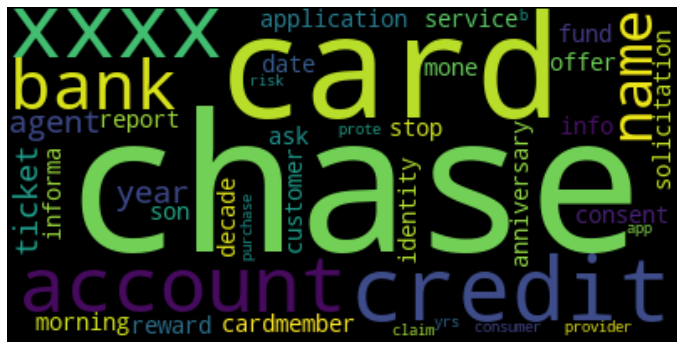

In [12]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(max_words=40, random_state=1, stopwords=set(STOPWORDS))
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [69]:
from nltk.util import ngrams 
from collections import Counter
from nltk.corpus import stopwords

nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def top_grams(gram_range):
    vec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=gram_range)
    grams = vec.fit_transform(df_clean['complaints_cleaned'])
    count_values = grams.toarray().sum(axis=0)
    vocab = vec.vocabulary_
    df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'unigram'})
    return df_ngram

In [16]:
df_unigram = top_grams((1, 1))
df_unigram.head(10)

,frequency,unigram
0,228814,xxxx
1,80783,chase
2,76983,xx
3,42737,account
4,32800,credit
5,26932,card
6,26753,bank
7,20360,would
8,16380,told
9,14120,payment


In [51]:
df_bigram = top_grams((2, 2))
df_bigram.head(10)

,frequency,unigram
0,90013,xxxx xxxx
1,38579,xx xx
2,29225,xx xxxx
3,12704,chase bank
4,10936,credit card
5,6234,xxxx xx
6,5120,xxxx chase
7,3662,called chase
8,3567,checking account
9,3247,credit report


#### The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [31]:
df_clean['complaints_cleaned'] = df_clean['complaints_cleaned'].str.replace('xxxx','')
df_clean['complaints_cleaned'] = df_clean['complaints_cleaned'].str.replace('xxx','')
df_clean['complaints_cleaned'] = df_clean['complaints_cleaned'].str.replace('xx','')

In [32]:
#All masked texts has been removed
df_clean

,complaints_cleaned,complaints_lemmatized,complaint_POS_removed
0,good morning my name is and i appreciate it ...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
1,i upgraded my card in // and was told by the...,I upgrade my xxxx xxxx card in xx / xx/ and be...,xxxx card agent anniversary date agent informa...
2,"chase card was reported on //. however, fraudu...","chase card be report on xx / xx/. however , fr...",chase card report application identity consent...
3,"on //, while trying to book a ticket, i ca...","on xx / xx/ , while try to book a xxxx xxxx ...",xxxx xxxx ticket offer ticket reward card info...
4,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund chase bank account mone...
...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
21068,"on wednesday, // i called chas, my visa cred...","on wednesday , xx / xx / xxxx I call chas , my...",xxxx credit card provider claim purchase prote...
21069,i am not familiar with pay and did not unders...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...
21070,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...,credit yrs chase credit card chase freedom pro...


## Step 5: Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [80]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [81]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaints_cleaned'])

## Step 6: Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [35]:
from sklearn.decomposition import NMF

#### Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [36]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [37]:
W = nmf_model.fit_transform(dtm)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

In [38]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)),
                           index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}'
                                    for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,card,chase,charges,charge,dispute,fraud,called,received,did,told,merchant,claim,transaction,said,refund
Topic 2,credit,card,report,inquiry,chase,inquiries,hard,cards,reporting,score,accounts,account,closed,debt,removed
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,payments,house,bank,years,sale,morgan,rate,jp
Topic 4,account,bank,check,chase,money,funds,checking,closed,deposit,branch,told,accounts,deposited,said,business
Topic 5,payment,late,payments,balance,paid,pay,month,fees,fee,statement,auto,account,chase,charged,monthly


In [39]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping_num = {
    'Topic 1' : 0,
    'Topic 2' : 1,
    'Topic 3' : 2,
    'Topic 4' : 3,
    'Topic 5' : 4
}

In [40]:
Wi = pd.DataFrame(W, columns=[f'Topic {i+1}' for i in range(num_topics)])
Wi['max_topic'] = Wi.apply(lambda x: topic_mapping_num.get(x.idxmax())
                         if x.idxmax() in topic_mapping_num.keys() else '4',
                         axis=1)
Wi[pd.notnull(Wi['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.008554,0.011177,0.026329,0.022077,0.005122,2
1,0.012205,0.005017,0.001986,0.005902,0.003142,0
2,0.010476,0.042645,0.000428,0.000000,0.000000,1
3,0.022715,0.047093,0.017815,0.018156,0.000000,1
4,0.002875,0.000000,0.003752,0.066666,0.000221,3
5,0.000000,0.043195,0.000000,0.000000,0.000000,1
6,0.002330,0.000073,0.007773,0.060834,0.017323,3
7,0.013461,0.000000,0.033320,0.000000,0.043369,4
8,0.056248,0.000000,0.011340,0.017704,0.000246,0
9,0.005799,0.093884,0.000000,0.000000,0.000000,1


In [41]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = W.argmax(axis=1)

In [42]:
df_clean.head()

,complaints_cleaned,complaints_lemmatized,complaint_POS_removed,Topic
0,good morning my name is and i appreciate it ...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,2
1,i upgraded my card in // and was told by the...,I upgrade my xxxx xxxx card in xx / xx/ and be...,xxxx card agent anniversary date agent informa...,0
2,"chase card was reported on //. however, fraudu...","chase card be report on xx / xx/. however , fr...",chase card report application identity consent...,1
3,"on //, while trying to book a ticket, i ca...","on xx / xx/ , while try to book a xxxx xxxx ...",xxxx xxxx ticket offer ticket reward card info...,1
4,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund chase bank account mone...,3


In [44]:
#Print the first 5 Complaint for each of the Topics
df_clean.groupby('Topic').head(5)

,complaints_cleaned,complaints_lemmatized,complaint_POS_removed,Topic
0,good morning my name is and i appreciate it ...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,2
1,i upgraded my card in // and was told by the...,I upgrade my xxxx xxxx card in xx / xx/ and be...,xxxx card agent anniversary date agent informa...,0
2,"chase card was reported on //. however, fraudu...","chase card be report on xx / xx/. however , fr...",chase card report application identity consent...,1
3,"on //, while trying to book a ticket, i ca...","on xx / xx/ , while try to book a xxxx xxxx ...",xxxx xxxx ticket offer ticket reward card info...,1
4,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund chase bank account mone...,3
5,can you please remove inquiry,can you please remove inquiry,inquiry,1
6,with out notice j.p. morgan chase restricted m...,with out notice j.p . morgan chase restrict my...,account debit card branch customer service rep...,3
7,"during the summer months, i experience a decli...","during the summer month , I experience a decli...",summer month decline income employment month p...,4
8,"on //, i made a {$.} payment to an online ret...","on xxxx xx / xx/ , I make a { $ . } payment to...",payment retailer chase pay xxxx chase website ...,0
9,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,credit card datum credit report company issue,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [45]:
#Create the dictionary of Topic names and Topics

Topic_names = { 
    0:"Bank Account services",
    1:"Credit card or prepaid card",
    2:"Theft/Dispute Reporting",
    3:"Mortgage/Loan",
    4:"Others"
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [46]:
df_clean.shape

(21072, 4)

In [47]:
df_clean.Topic.value_counts()

Mortgage/Loan                  5585
Bank Account services          4631
Credit card or prepaid card    4397
Theft/Dispute Reporting        3835
Others                         2624
Name: Topic, dtype: int64

## Step 7: Model building

Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [48]:
#Create the dictionary again of Topic names and Topics
Topic_names = {  
    "Bank Account services":0,
    "Credit card or prepaid card":1,
    "Theft/Dispute Reporting":2,
    "Mortgage/Loan":3,
    "Others":4
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [49]:
df_clean

,complaints_cleaned,complaints_lemmatized,complaint_POS_removed,Topic
0,good morning my name is and i appreciate it ...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,2
1,i upgraded my card in // and was told by the...,I upgrade my xxxx xxxx card in xx / xx/ and be...,xxxx card agent anniversary date agent informa...,0
2,"chase card was reported on //. however, fraudu...","chase card be report on xx / xx/. however , fr...",chase card report application identity consent...,1
3,"on //, while trying to book a ticket, i ca...","on xx / xx/ , while try to book a xxxx xxxx ...",xxxx xxxx ticket offer ticket reward card info...,1
4,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son chase account fund chase bank account mone...,3
...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,1
21068,"on wednesday, // i called chas, my visa cred...","on wednesday , xx / xx / xxxx I call chas , my...",xxxx credit card provider claim purchase prote...,0
21069,i am not familiar with pay and did not unders...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,0
21070,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I 've ...,credit yrs chase credit card chase freedom pro...,4


In [50]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaints_cleaned","Topic"]]

In [51]:
training_data

,complaints_cleaned,Topic
0,good morning my name is and i appreciate it ...,2
1,i upgraded my card in // and was told by the...,0
2,"chase card was reported on //. however, fraudu...",1
3,"on //, while trying to book a ticket, i ca...",1
4,my grand son give me check for {$.} i deposit ...,3
...,...,...
21067,after being a chase card customer for well ove...,1
21068,"on wednesday, // i called chas, my visa cred...",0
21069,i am not familiar with pay and did not unders...,0
21070,i have had flawless credit for yrs. i've had ...,4


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [52]:
from sklearn.feature_extraction.text import TfidfTransformer

# Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints_cleaned)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)


In [56]:
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       945
           1       0.96      0.95      0.96       916
           2       0.98      0.95      0.96       714
           3       0.94      0.98      0.96      1120
           4       0.97      0.90      0.93       520

    accuracy                           0.95      4215
   macro avg       0.96      0.95      0.95      4215
weighted avg       0.95      0.95      0.95      4215



In [57]:
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       945
           1       0.82      0.82      0.82       916
           2       0.79      0.83      0.81       714
           3       0.80      0.80      0.80      1120
           4       0.71      0.68      0.69       520

    accuracy                           0.77      4215
   macro avg       0.77      0.77      0.77      4215
weighted avg       0.77      0.77      0.77      4215



In [58]:
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.84      0.67      0.75       945
           1       0.80      0.83      0.82       916
           2       0.89      0.80      0.84       714
           3       0.62      0.97      0.75      1120
           4       1.00      0.19      0.31       520

    accuracy                           0.75      4215
   macro avg       0.83      0.69      0.69      4215
weighted avg       0.80      0.75      0.73      4215



## Step 8: Model Inference

We can see that the LogisticRegression has performed the best

In [65]:
sample_complaint = ["This is the notification addressing the dispute against +\
the amount that was mistakenly charged to my credit card. My credit card  +\
number, XCXCXXC, keeps a running log of all payments made on time for all  +\
invoices. I want to let you know that the bank statement they sent me,  +\
dated February 20, 2014, has an incorrect charge for Rs. 10,000. An image  +\
of the statement with the false accusation circled in red is included in this  +\
message. Since I returned the item shortly after, this particular payment was  +\
canceled the same day. It was billed under the name of -Creditor. I've sent a  +\
copy of the cancelled bill and the creditor's signed authorization. To my  +\
great surprise, this amount was included in my bills because never before  +\
has such an error happened in the billings of my credit card."]

In [86]:
Topic_names = { 
    0:"Bank Account services",
    1:"Credit card or prepaid card",
    2:"Theft/Dispute Reporting",
    3:"Mortgage/Loan",
    4:"Others"
}

X_new_counts = count_vect.transform(sample_complaint)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = lr.predict(X_new_tfidf)
Topic_names[predicted[0]]

'Credit card or prepaid card'

### We were able to successfully classify the complaints